<h1 style="text-align: center; color: #1976D2; font-family: Arial, sans-serif;">
  Logistic Regression Analysis
</h1>

<h3 style="text-align: center; color: #1565C0; font-family: Arial, sans-serif;">
  Travel Insurance Claim Classification Project
</h3>

<hr style="border: 1px solid #BBDEFB;">

<p style="font-size: 16px; color: #0D47A1; font-family: 'Segoe UI', sans-serif; line-height: 1.6; text-align: justify;">
  This notebook presents a <strong>logistic regression</strong> model designed to solve a classification task in the context of <strong>travel insurance</strong>. The goal is to predict whether a customer will make an insurance <strong><em>claim</em></strong> based on features such as demographics, trip length, customer score, agent interactions, and policy details.
</p>

<ul style="font-size: 15px; color: #0D47A1; font-family: 'Segoe UI', sans-serif; line-height: 1.6;">
  <li><strong>Author:</strong> Giacomo Fantato &mdash; <code>K-16958</code></li>
  <li><strong>Date:</strong> May 26, 2025</li>
  <li><strong>Tools Used:</strong> Python, <code>scikit-learn</code>, <code>pandas</code>, <code>matplotlib</code>, <code>seaborn</code></li>
</ul>

<hr style="border: 1px solid #BBDEFB;">


## Create pickle file cleaned for the analysis 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, GridSearchCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import pandas as pd
import pickle
from sklearn.feature_selection import VarianceThreshold


from scipy.stats import chi2_contingency

In [3]:
def reduce_rare_categories(df, nominal_columns, threshold=25):
    for col in nominal_columns:
        if col in df.columns:
            value_counts = df[col].value_counts()
            rare_levels = value_counts[value_counts <= threshold].index
            df[col] = df[col].replace(rare_levels, "Other")
    return df

def drop_near_zero_variance(df, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []
    cols_to_check = [col for col in df.columns if col not in exclude_columns]
    selector = VarianceThreshold(threshold=1e-4)
    selector.fit(df[cols_to_check])
    retained = selector.get_support(indices=True)
    retained_columns = [cols_to_check[i] for i in retained]
    return df[exclude_columns + retained_columns]

def prepare_full_pipeline(train_csv, test_csv, nominal_columns,
                          save_train_clean_pkl, save_test_clean_pkl,
                          save_train_encoded_pkl, save_test_encoded_pkl):
    print("Loading data...")
    train_df = pd.read_csv(train_csv).dropna()
    test_df = pd.read_csv(test_csv).dropna()

    # Salvataggio dataset puliti (solo NA rimossi)
    print("Saving dataset clean (NA removed)...")
    with open(save_train_clean_pkl, "wb") as f:
        pickle.dump(train_df, f)
    with open(save_test_clean_pkl, "wb") as f:
        pickle.dump(test_df, f)

    # Riduzione categorie rare
    print("Reducing rare categories (≤25)...")
    train_df = reduce_rare_categories(train_df.copy(), nominal_columns, threshold=25)
    test_df = reduce_rare_categories(test_df.copy(), nominal_columns, threshold=25)

    # One-hot encoding
    print("One-hot encoding...")
    train_encoded = pd.get_dummies(train_df, columns=nominal_columns, drop_first=False, dtype=int)
    test_encoded = pd.get_dummies(test_df, columns=nominal_columns, drop_first=False, dtype=int)

    # Allineamento colonne test -> train
    print("Aligning test columns with train...")
    test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

    # Eliminazione near-zero variance
    print("Removing low variance variables...")
    target_col = "claim_status" if "claim_status" in train_encoded.columns else None
    exclude = [target_col] if target_col else []

    train_encoded = drop_near_zero_variance(train_encoded, exclude_columns=exclude)

    # Allinea solo le colonne delle feature (senza target)
    features_only = [col for col in train_encoded.columns if col != target_col]
    test_encoded = test_encoded.reindex(columns=features_only, fill_value=0)

    # Salvataggio finali
    print("Saving final dataset encoded...")
    with open(save_train_encoded_pkl, "wb") as f:
        pickle.dump(train_encoded, f)
    with open(save_test_encoded_pkl, "wb") as f:
        pickle.dump(test_encoded, f)

    print("Completed!")


In [4]:
import os
nominal_vars = [
    'person_gender', 'entity_type', 'channel',
    'agent_id', 'entity_a', 'location', 'product_id'
]

os.makedirs("data/classification", exist_ok=True)


prepare_full_pipeline(
    train_csv="../data/insurance_train.csv",
    test_csv="../data/insurance_test.csv",
    nominal_columns=nominal_vars,
    save_train_clean_pkl="data/classification/classification_train_clean.pkl",
    save_test_clean_pkl="data/classification/classification_test_clean.pkl",
    save_train_encoded_pkl="data/classification/clasisfication_train_encoded.pkl",
    save_test_encoded_pkl="data/classification/classification_test_encoded.pkl"
)

Loading data...
Saving dataset clean (NA removed)...
Reducing rare categories (≤25)...
One-hot encoding...
Aligning test columns with train...
Removing low variance variables...
Saving final dataset encoded...
Completed!


---

## Import data and check consistency

In [5]:
import pickle
import pandas as pd

# Load and assign to DataFrames
train_clean_df = pd.read_pickle("data/classification/classification_train_clean.pkl")
test_clean_df = pd.read_pickle("data/classification/classification_test_clean.pkl")
train_encoded_df = pd.read_pickle("data/classification/clasisfication_train_encoded.pkl")
test_encoded_df = pd.read_pickle("data/classification/classification_test_encoded.pkl")

# Optional: Confirm they're pandas DataFrames
print("Data types:")
print("train_clean_df:", type(train_clean_df))
print("test_clean_df:", type(test_clean_df))
print("train_encoded_df:", type(train_encoded_df))
print("test_encoded_df:", type(test_encoded_df))

# Preview contents
print("\n train_clean_df:")
print(train_clean_df.info())

print("\n test_clean_df:")
print(test_clean_df.info())

print("\n train_encoded_df:")
print(train_encoded_df.info())

print("\n test_encoded_df:")
print(test_encoded_df.info())


Data types:
train_clean_df: <class 'pandas.core.frame.DataFrame'>
test_clean_df: <class 'pandas.core.frame.DataFrame'>
train_encoded_df: <class 'pandas.core.frame.DataFrame'>
test_encoded_df: <class 'pandas.core.frame.DataFrame'>

 train_clean_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56993 entries, 0 to 56992
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reward                56993 non-null  float64
 1   claim_status          56993 non-null  int64  
 2   person_gender         56993 non-null  object 
 3   entity_type           56993 non-null  object 
 4   channel               56993 non-null  object 
 5   support_interactions  56993 non-null  int64  
 6   agent_id              56993 non-null  object 
 7   customer_score        56993 non-null  float64
 8   entity_a              56993 non-null  object 
 9   person_age            56993 non-null  int64  
 10  location              5699

In [9]:
train_encoded_df.head()


,claim_status,reward,support_interactions,customer_score,person_age,revenue,trip_length,person_gender_08f27188,person_gender_9b2d5b46,person_gender_f67ab10a,...,product_id_TravelShield Premium,product_id_TravelShield Value,product_id_TripGuard Annual Lite,product_id_TripGuard Annual Max,product_id_TripGuard Annual Pro,product_id_TripGuard Cancel,product_id_TripGuard Max,product_id_TripGuard Plus,product_id_TripGuard Pro,product_id_TripGuard TicketCover
0,0,0.000000,0,0.284509,51,105.459587,21,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,18.428627,0,0.207538,32,30.433459,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.000000,1,0.300461,38,78.728474,84,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0.000000,0,0.132404,30,17.146843,39,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0.000000,2,0.070443,37,10.476416,48,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
test_encoded_df.head()

,reward,support_interactions,customer_score,person_age,revenue,trip_length,person_gender_08f27188,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_a,...,product_id_TravelShield Premium,product_id_TravelShield Value,product_id_TripGuard Annual Lite,product_id_TripGuard Annual Max,product_id_TripGuard Annual Pro,product_id_TripGuard Cancel,product_id_TripGuard Max,product_id_TripGuard Plus,product_id_TripGuard Pro,product_id_TripGuard TicketCover
0,84.316320,2,0.009257,31,-141.716239,73,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,45.884363,0,0.108049,29,82.225268,25,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,2,0.108814,26,10.247118,6,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,29.363482,1,0.215505,32,83.483247,73,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,12.440951,0,0.194798,26,46.679372,32,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---

## Finding the best model (execute only to search best model)
In this part we'll see how i can achieved the bsest model using GridSearch and K-folder validation

Training set shape: (34195, 126)
Validation set shape: (22798, 126)
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters found:
{'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

Best Balanced Accuracy (CV average):
0.7513

Balanced Accuracy and AUC for each fold:
Fold 1: Balanced Accuracy = 0.7438, AUC = 0.8032
Fold 2: Balanced Accuracy = 0.6897, AUC = 0.7369
Fold 3: Balanced Accuracy = 0.7762, AUC = 0.8295
Fold 4: Balanced Accuracy = 0.7731, AUC = 0.8253
Fold 5: Balanced Accuracy = 0.7736, AUC = 0.8307

Evaluation on the TRAINING SET

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     33695
           1       0.05      0.79      0.09       500

    accuracy                           0.76     34195
   macro avg       0.52      0.77      0.47     34195
weighted avg       0.98      0.76      0.85     34195

Balanced Accuracy (Train): 0.7727
AUC (Train): 0.

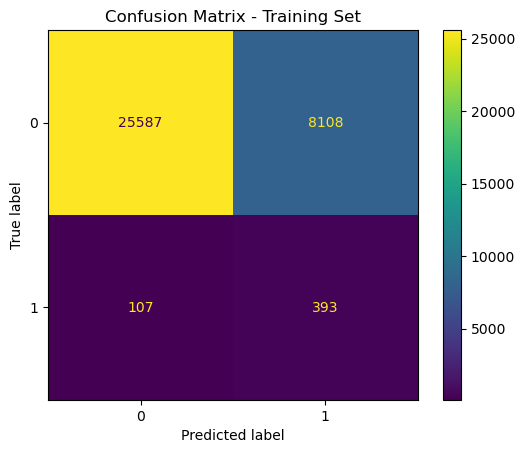

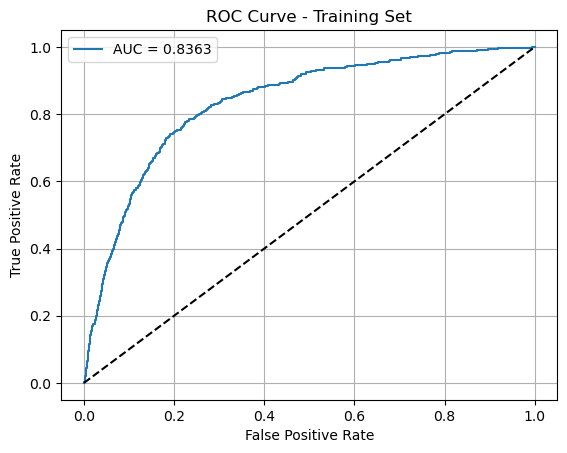


Evaluation on the VALIDATION SET

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     22464
           1       0.04      0.74      0.08       334

    accuracy                           0.76     22798
   macro avg       0.52      0.75      0.47     22798
weighted avg       0.98      0.76      0.85     22798

Balanced Accuracy (Validation): 0.7466
AUC (Validation): 0.8111


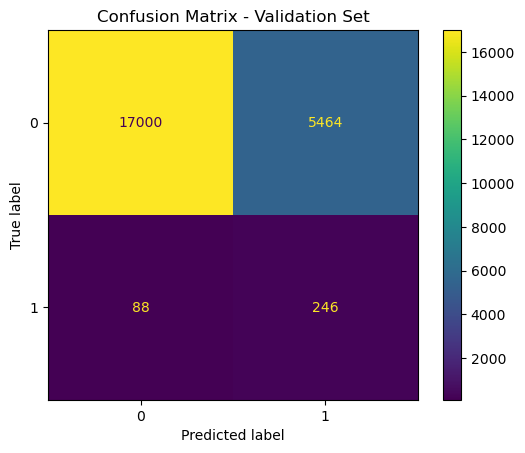

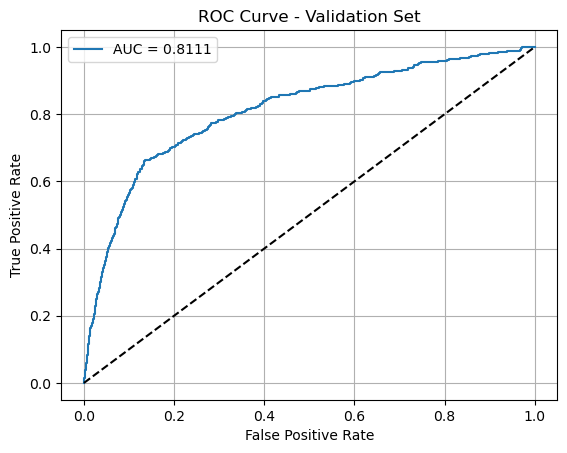

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    ConfusionMatrixDisplay, classification_report, balanced_accuracy_score
)

# Split the dataset into training and validation sets (60/40)
train_df, val_df = train_test_split(
    train_encoded_df, 
    test_size=0.4, 
    random_state=42, 
    stratify=train_encoded_df["claim_status"]
)
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)

# Define features and target
agent_cols = [col for col in train_df.columns if col.startswith("agent_id_")]
entity_cols = [col for col in train_df.columns if col.startswith("entity_a_")]
target_col = "claim_status"

X_train = train_df.drop(columns=agent_cols + entity_cols + [target_col], errors='ignore')
y_train = train_df[target_col]

X_val = val_df.drop(columns=agent_cols + entity_cols + [target_col], errors='ignore')
y_val = val_df[target_col]

# Stratified cross-validation
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Pipeline with Logistic Regression
logreg_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))
])

# Hyperparameter grid
param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10],
    "logreg__penalty": ["l1", "l2"],
    "logreg__solver": ["liblinear"]
}

# Grid search
grid_search = GridSearchCV( 
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

# Best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest Balanced Accuracy (CV average):")
print(f"{grid_search.best_score_:.4f}")

# Evaluation on each fold
print("\nBalanced Accuracy and AUC for each fold:")
fold_bal_accs = []
fold_aucs = []

for fold_idx, (train_idx, val_idx) in enumerate(cv5.split(X_train, y_train)):
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = grid_search.best_estimator_
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    bal_acc = balanced_accuracy_score(y_te, y_pred)
    auc = roc_auc_score(y_te, y_proba)

    fold_bal_accs.append(bal_acc)
    fold_aucs.append(auc)

    print(f"Fold {fold_idx+1}: Balanced Accuracy = {bal_acc:.4f}, AUC = {auc:.4f}")

# Final evaluation on training set
print("\nEvaluation on the TRAINING SET")
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]

print("\nClassification Report (Training):")
print(classification_report(y_train, y_train_pred))
print(f"Balanced Accuracy (Train): {balanced_accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Confusion Matrix - Training Set")
plt.show()

fpr, tpr, _ = roc_curve(y_train, y_train_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_train, y_train_proba):.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Training Set")
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation on validation set
print("\nEvaluation on the VALIDATION SET")
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))
print(f"Balanced Accuracy (Validation): {balanced_accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC (Validation): {roc_auc_score(y_val, y_val_proba):.4f}")

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("Confusion Matrix - Validation Set")
plt.show()

fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val, y_val_proba):.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend()
plt.grid(True)
plt.show()



### Print best model parameters for reprudicibility

In [ ]:
# Ottieni i parametri dell'intera pipeline
best_pipeline_params = best_model.get_params()

# Oppure solo quelli del LogisticRegression interno
best_logreg_params = best_model.named_steps["logreg"].get_params()

# Stampa o salva i parametri
print("Best Logistic Regression Parameters:")
for param, value in best_logreg_params.items():
    print(f"{param}: {value}")


Best Logistic Regression Parameters:
C: 1
class_weight: balanced
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 1000
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


----

# Analyse best model found

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    ConfusionMatrixDisplay, classification_report, balanced_accuracy_score
)

# divide Train set in training and validation (60/40)
train_df, val_df = train_test_split(train_encoded_df, test_size=0.4, random_state=42, stratify=train_encoded_df["claim_status"])
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)

# Features e target
agent_cols = [col for col in train_df.columns if col.startswith("agent_id_")]
entity_cols = [col for col in train_df.columns if col.startswith("entity_a_")]
target_col = "claim_status"

X_train = train_df.drop(columns=agent_cols + entity_cols + [target_col], errors='ignore')
y_train = train_df[target_col]

#  Cross-validation stratified 
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Pipeline w/ Logistic Regression
logreg_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))
])

# Manual cross validation
fold_aucs = []
fold_bal_accs = []

for fold_idx, (train_idx, val_idx) in enumerate(cv5.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    logreg_pipeline.fit(X_tr, y_tr)
    y_val_pred = logreg_pipeline.predict(X_val)
    y_val_proba = logreg_pipeline.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_val_proba)
    bal_acc = balanced_accuracy_score(y_val, y_val_pred)

    fold_aucs.append(auc)
    fold_bal_accs.append(bal_acc)

    print(f"Fold {fold_idx + 1}: ROC AUC = {auc:.4f}, Balanced Accuracy = {bal_acc:.4f}")

print(f"\n Average ROC AUC: {np.mean(fold_aucs):.4f}")
print(f" Average Balanced Accuracy: {np.mean(fold_bal_accs):.4f}")

# Final training on K-folder validation set
logreg_pipeline.fit(X_train, y_train)
y_train_pred = logreg_pipeline.predict(X_train)
y_train_proba = logreg_pipeline.predict_proba(X_train)[:, 1]


Training set shape: (34195, 126)
Validation set shape: (22798, 126)
Fold 1: ROC AUC = 0.8034, Balanced Accuracy = 0.7434
Fold 2: ROC AUC = 0.7366, Balanced Accuracy = 0.6892
Fold 3: ROC AUC = 0.8294, Balanced Accuracy = 0.7760
Fold 4: ROC AUC = 0.8253, Balanced Accuracy = 0.7733
Fold 5: ROC AUC = 0.8300, Balanced Accuracy = 0.7737

 Average ROC AUC: 0.8050
 Average Balanced Accuracy: 0.7511


### Training set: printing the final result (graphically)

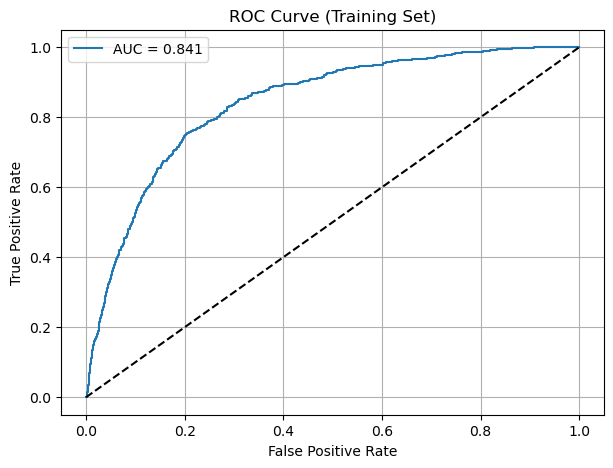

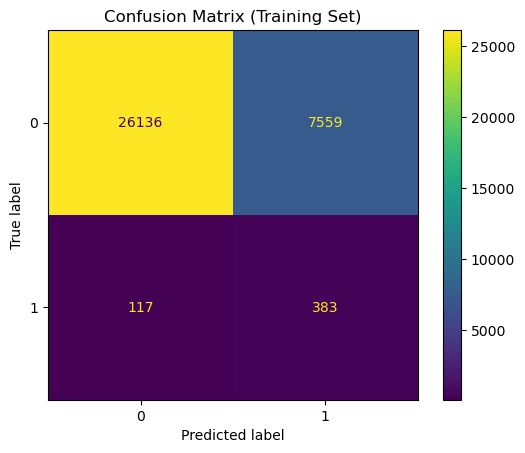


 Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     33695
           1       0.05      0.77      0.09       500

    accuracy                           0.78     34195
   macro avg       0.52      0.77      0.48     34195
weighted avg       0.98      0.78      0.86     34195



In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_train, y_train_proba)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_train, y_train_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Training Set)")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(logreg_pipeline, X_train, y_train)
plt.title("Confusion Matrix (Training Set)")
plt.show()

# Classification Report
print("\n Classification Report (Training Set):")
print(classification_report(y_train, y_train_pred))


### Validate the model:


Validation Set Metrics:
ROC AUC: 0.8180
Balanced Accuracy: 0.7494


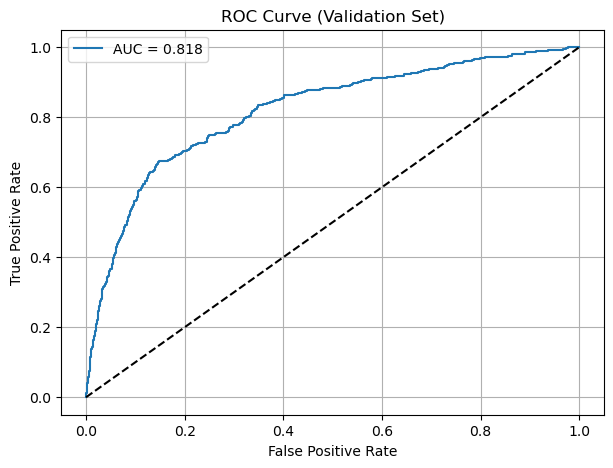

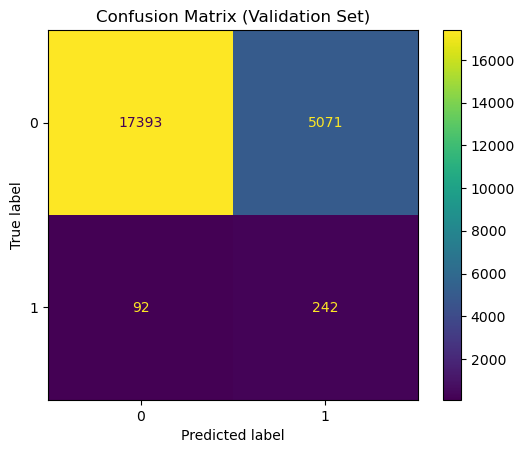


 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     22464
           1       0.05      0.72      0.09       334

    accuracy                           0.77     22798
   macro avg       0.52      0.75      0.48     22798
weighted avg       0.98      0.77      0.86     22798



In [13]:
# Prepare validation set
X_val = val_df.drop(columns=agent_cols + entity_cols + [target_col], errors='ignore')
y_val = val_df[target_col]

# Predictions on validation set
y_val_pred = logreg_pipeline.predict(X_val)
y_val_proba = logreg_pipeline.predict_proba(X_val)[:, 1]

# Metrics  su validation
print("\nValidation Set Metrics:")
print(f"ROC AUC: {roc_auc_score(y_val, y_val_proba):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_val_pred):.4f}")

# ROC Curve validation
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val, y_val_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix validation
ConfusionMatrixDisplay.from_estimator(logreg_pipeline, X_val, y_val)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# Classification report validation
print("\n Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))


---

# Overfitting Check

Overfitting occurs when a model performs very well on the training data but poorly on unseen (validation or test) data. This usually means the model has learned patterns specific to the training set that do not generalize well.

### Common signs of overfitting:
| Metric             | Training Set       | Validation Set     | Interpretation                      |
|-------------------|--------------------|--------------------|-------------------------------------|
| Accuracy / Balanced Accuracy | Very high (e.g. > 90%) | Much lower (e.g. < 70%) | The model is memorizing training data |
| AUC                | Very high (e.g. > 0.90) | Lower              | Poor generalization capability      |
| Confusion Matrix   | Few errors         | Many errors        | Strong performance gap              |
| Classification Report | High precision/recall | Low precision/recall | Model likely overfitting            |


### What to do if overfitting is detected:

- **Stronger regularization**: Lower the `C` value in Logistic Regression (e.g., `C = 0.01`).
- **Feature selection**: Remove irrelevant or redundant variables.
- **Simplify the model**: Reduce complexity if using too many categorical dummies.
- **Add more data**: More samples help generalization.
- **Robust cross-validation**: Use more folds (e.g., 10-fold CV).



In [20]:
# ========================
# Automatic Overfitting Check
# ========================

# Define a simple threshold for performance gap
auc_gap = roc_auc_score(y_train, y_train_proba) - roc_auc_score(y_val, y_val_proba)
ba_gap = balanced_accuracy_score(y_train, y_train_pred) - balanced_accuracy_score(y_val, y_val_pred)

# Print the metrics
print("\n=== Overfitting Check (5%) ===")
print(f"Train AUC:              {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"Validation AUC:         {roc_auc_score(y_val, y_val_proba):.4f}")
print(f"AUC Gap:                {auc_gap:.4f}")
print(f"Train Balanced Accuracy:      {balanced_accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Balanced Accuracy: {balanced_accuracy_score(y_val, y_val_pred):.4f}")
print(f"Balanced Accuracy Gap:        {ba_gap:.4f}")

# Check for overfitting --> check is 0.05 (or 5 percentage points) 
if auc_gap > 0.05 or ba_gap > 0.05:
    print("\nPotential overfitting detected: the model performs significantly better on the training set.")
else:
    print("\nNo significant overfitting detected.")



=== Overfitting Check (5%) ===
Train AUC:              0.8363
Validation AUC:         0.8111
AUC Gap:                0.0252
Train Balanced Accuracy:      0.7727
Validation Balanced Accuracy: 0.7466
Balanced Accuracy Gap:        0.0260

No significant overfitting detected.


---

## Prediction task

In [32]:
import numpy as np
import pandas as pd

# 1. Create a unique auto-incremental ID for each row in the test set
test_encoded_df = test_encoded_df.copy()
test_encoded_df["autoincrement_id"] = np.arange(len(test_encoded_df))

# 2. Drop columns that were excluded during training
agent_cols = [col for col in test_encoded_df.columns if col.startswith("agent_id_")]
entity_cols = [col for col in test_encoded_df.columns if col.startswith("entity_a_")]

X_test = test_encoded_df.drop(columns=agent_cols + entity_cols + ["autoincrement_id"], errors="ignore")

# 3. Align test features with the exact feature set used during training
expected_features = X_train.columns.tolist()
X_test = X_test.reindex(columns=expected_features, fill_value=0)

# 4. Make predictions using the trained model
y_test_pred = model.predict(X_test)

# 5. Create and save the submission file
submission_df = pd.DataFrame({
    "autoincrement_id": test_encoded_df["autoincrement_id"],
    "claim_status_pred": y_test_pred
})
submission_df.to_csv("../data/results/classification_predictions.csv", index=False)
print("File 'classification_predictions.csv' saved successfully.")


File 'classification_predictions.csv' saved successfully.


In [33]:
# integrity check
if len(y_test_pred) == len(test_encoded_df):
    print("Prediction length matches the test set.")
else:
    print("Mismatch: predicted values and test set length differ.")


Prediction length matches the test set.


Class distribution:
claim_status_pred
0    4815
1    1518
Name: count, dtype: int64

Percentage distribution:
claim_status_pred
0    76.03
1    23.97
Name: proportion, dtype: float64


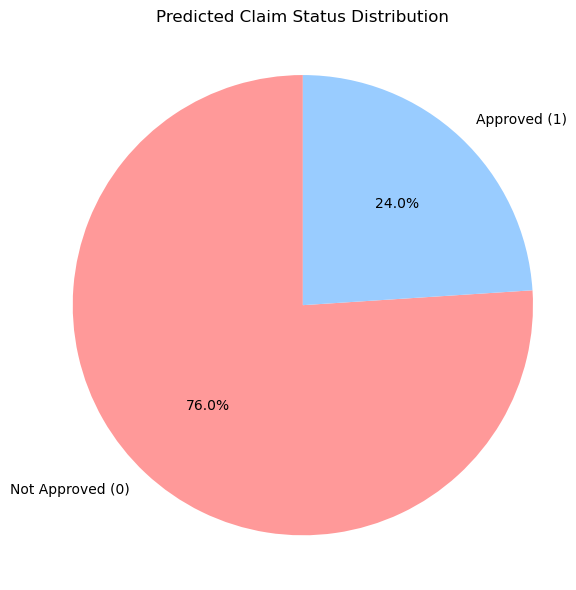

In [35]:
# 1. Read predictions file
predictions = pd.read_csv("../data/results/classification_predictions.csv")

# 2. Count and percentage of each class
class_counts = predictions["claim_status_pred"].value_counts()
class_percent = predictions["claim_status_pred"].value_counts(normalize=True) * 100

print("Class distribution:")
print(class_counts)
print("\nPercentage distribution:")
print(class_percent.round(2))

# 3. Pie chart
labels = ['Not Approved (0)', 'Approved (1)']
sizes = [class_percent.get(0, 0), class_percent.get(1, 0)]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=["#FF9999", "#99CCFF"])
plt.title("Predicted Claim Status Distribution")
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.tight_layout()
plt.show()


---

## Optional: save predictions in the Test Set


In [36]:
test_predictions = test_clean_df.copy()
test_predictions["predictions"] = y_test_pred
test_predictions.head()


,reward,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length,predictions
0,84.316320,9b2d5b46,type_a,web,2,agt_0001,0.009257,96d6c6df,31,ireland,-141.716239,DriveSafe Rental Addon,73,0
1,45.884363,9b2d5b46,type_a,web,0,agt_0001,0.108049,96d6c6df,29,australia,82.225268,DriveSafe Rental Addon,25,1
2,0.000000,9b2d5b46,type_a,web,2,agt_0004,0.108814,50b3e71e,26,indonesia,10.247118,TripGuard Cancel,6,0
3,29.363482,f67ab10a,type_b,web,1,agt_0002,0.215505,7b5dbb09,32,france,83.483247,TravelShield Value,73,0
4,12.440951,08f27188,type_b,web,0,agt_0005,0.194798,99ede4e4,26,singapore,46.679372,TravelShield Plus,32,1


### Optional 2: export to csv file

In [37]:
test_predictions.to_csv("../data/results/test_classification.csv", index=False)
print("File 'test_classification.csv' saved successfully.")

File 'test_classification.csv' saved successfully.
